----------------------------------

# PART III
# ML regression

Cacharreanding stuff


![alt](https://i.pinimg.com/originals/8c/5c/59/8c5c5923c547867c1615402754d9eb27.gif)
-----------------------------------

*This jupyter is the explanation. The *real thing* is available in the **Cloud Function** folder. 


----------------------------------

I'm going to:

- Normalise the dataset before applying ML. 
- Use **RFE** (Recursive Feature Elimination) to select the best 15 columns to work with, from the 133 I have.
- Use the fastest regression I can. Speed over performance due to Cloud Function requirements.
- Perform cross validation. Unfortunately I have no enough data for train/validation/test
- Once my model is trained, infer data in the whole dataset, to have a dashboard comparing *real keyword* vs *infered keyword*.

Let's have fun :D

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA as pca
from scipy import stats
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [2]:
df=pd.read_csv("input/dataset_final_processed.csv",index_col=[0])

### First attributes selection: Erasing low variance elements

Let's remove the attibutes (columns) which values are quite constant in the whole dataset, so they're not offering much information when everything else is changing.

In [3]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold):
    '''
    It removes any attribute (column) than vary less than the percentaje of the threshold
    '''
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [4]:
low_v = df.drop(columns=["date","unemployment","outliers_score" ])

In [5]:
X_raw= variance_threshold_selector(low_v, 5) # removing values than vary less than 5%
print("attributes before", low_v.shape,"attributes now", X_raw.shape)

attributes before (87, 118) attributes now (87, 109)


In [6]:
print("removed features: ","\n")
for c in low_v.columns:
    if c not in X_raw.columns:
        print(c)

removed features:  

precio_petroleo_1
prosperidad_economica_y_finanzas
inflacion_economica
precio_petroleo_2
banco_mundial
censura_en_medios
subsidios
desescalada
hacer deporte


### Normalization / Standarization

Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

In other hand, Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data

In [7]:
# Normalizacion with sklearn
# remove dates and target
#X_raw = df.drop(columns=["date","unemployment","outliers_score" ]) #already removed in low_v

normalizer = preprocessing.MinMaxScaler()
X = pd.DataFrame(normalizer.fit_transform(X_raw))

#standardizer = preprocessing.StandardScaler()
#X = pd.DataFrame(standardizer.fit_transform(X_raw))

X.columns= X_raw.columns
X.shape
target=df["unemployment"]
X.head(2)

,vigilancia,inestabilidad_politica,rebelion,terrorismo,protestas,corrupcion_1,refugiados_1,ejercito,seguridad_nacional,extremismo,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,0.640186,0.894425,0.579915,0.438318,0.995760,0.705565,0.780032,0.893647,0.420146,0.664755,...,0.43,0.01,0.57,0.27,0.12,0.052632,0.166667,0.34,0.870370,0.142857
1,0.231892,0.778049,0.654679,0.928255,0.835291,0.398453,0.701877,0.823433,0.765143,0.929841,...,0.50,0.01,0.45,0.39,0.09,0.105263,0.083333,0.27,0.814815,0.114286


### Validation (nested validation)

I'll validate the algorithoms with the training set. To tune it properly I'll create a substet test from the training set. 

In [8]:
# splitting
X_train=X.iloc[:-4]
target_train=target.iloc[:-4]

# last 4 rows, which are the ones I have no data and I want to infer
X_test=X.iloc[-4:]
target_test=target.iloc[-4:]

In [60]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import  RandomForestClassifier
import pandas as pd

X, y = X_train, target_train

clf=RandomForestClassifier(n_estimators =10, random_state = 42) # , class_weight="balanced" no tiene sentido aquí
output = cross_validate(clf, X, y, cv=5, scoring = 'neg_mean_squared_error', return_estimator =True)

/home/vargas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [61]:
for idx,estimator in enumerate(output['estimator']):
    #print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    #display(feature_importances)

In [62]:
feature_importances.head(20)

,importance
infeccion,0.027960
psoe,0.026526
cursos online,0.025305
emprendimiento_1,0.022786
cabify,0.021270
hangouts,0.020886
compartir piso,0.018634
taxi,0.018614
stock_market,0.018512
divorcio,0.018302


Feature: 0, Score: 0.85082
Feature: 1, Score: -8.37280
Feature: 2, Score: 0.74595
Feature: 3, Score: 11.47389
Feature: 4, Score: -12.98725
Feature: 5, Score: -1.88574
Feature: 6, Score: -2.78934
Feature: 7, Score: -5.88255
Feature: 8, Score: -18.14319
Feature: 9, Score: 19.43263
Feature: 10, Score: 7.90972
Feature: 11, Score: 6.42949
Feature: 12, Score: 2.08621
Feature: 13, Score: -16.87046
Feature: 14, Score: 8.39150
Feature: 15, Score: 0.61275
Feature: 16, Score: -20.02764
Feature: 17, Score: -11.41363
Feature: 18, Score: 7.74760
Feature: 19, Score: -0.78119
Feature: 20, Score: -10.26642
Feature: 21, Score: 6.44610
Feature: 22, Score: 3.59870
Feature: 23, Score: -25.40904
Feature: 24, Score: 28.08442
Feature: 25, Score: 0.56143
Feature: 26, Score: 1.61710
Feature: 27, Score: -0.66056
Feature: 28, Score: -27.90361
Feature: 29, Score: 30.39845
Feature: 30, Score: -31.82151
Feature: 31, Score: -7.83292
Feature: 32, Score: -12.28651
Feature: 33, Score: -14.79330
Feature: 34, Score: -23.4

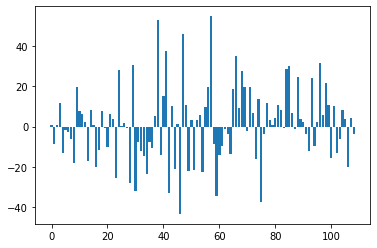

In [66]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
X, y = X_train, target_train
# define the model
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [ ]:
# all but last 4 rows
X_train=X.iloc[:-4]
target_train=target.iloc[:-4]

# last 4 rows, which are the ones I have no data and I want to infer
X_test=X.iloc[-4:]
target_test=target.iloc[-4:]

# Model selection

Here is where I run different models and perform tunning of hyperparameter for better fit, and:

- Divide between train/validation/test
- Train the models with train
- Validate metrics with validation
- Perform inferences with test
- Select the best model of all and train it with the whole dataset

**That's not going to happen... Yet**. This is a leisure project and my main concern is having something that works within a Cloud Function, in my GCP pipelines. It means my baby needs to run with 4GB of RAM as maximum and 60 seconds of timeout, so I will start with the simplest and fastest model I can.

When I get that, myself from the future will refactorize code and improve metrics. 

So, right now, the selected model will be a Lasso regression after a recursive feature elimination. 

- The model will select the 15 best columns to work with.
- After it, Lasso will remove from the equation the less relevants.

It is like a double filter of simplicity that I hope it works

# Selecting best features using RFE

(Recursive Feature Elimination)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [72]:
# My number of features will be a tenth of the available fows
number_features =  1+df.shape[0]//10

In [73]:
# alpha=1 is like a regular regression. for getter performance use elastic net instead (l1&l2 mix).
#regression = Lasso(alpha=0.1)
regression = LinearRegression() # oher model

# neg mean squared error. it always is negative but what you get is the positive representation
rfecv = RFECV(estimator=regression, step=1, min_features_to_select=20, cv=5,scoring='neg_mean_squared_error')
rfecv.fit(X_train, target_train)

RFECV(cv=5,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=20, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [74]:


# it's unfortunate not having X and target validation, but k-folds cross validation was implemented for that precisely 
rfecv.score(X_train, target_train)



1.0

In [75]:
# Inferences 4 weeks ahead
rfecv.predict(X_test)

array([  31.42481095,   34.79688295,   51.79843886, -106.83937338])

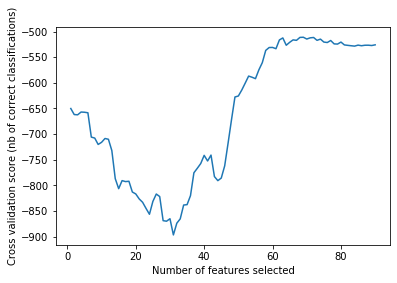

In [76]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
#plt.ylim([0, 1])
plt.show()

# https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [77]:
# Inferences 4 weeks ahead
rfecv.predict(X_test) 

array([  31.42481095,   34.79688295,   51.79843886, -106.83937338])

In [78]:
#rfecv.predict(X) # this is just for visualization

In [79]:
len(rfecv.predict(X))
len(df)

87

In [80]:
df["inferred_results"]=list(rfecv.predict(X))

ValueError: Length of values does not match length of index

# CSV with infered keyword vs real keyword

- Last 4 rows are the truly interesting ones... Foreseeing with 4 weeks in advance.

In [ ]:
result=pd.DataFrame()
result[["date", "real_searches"]]= df[["date","unemployment"]]
result["inferred_results"] = rfecv.predict(X)
result["inferred_results"]=result["inferred_results"].apply(lambda x: 0 if x<0 else round(x,2))
result["inferred_results"]=result["inferred_results"].apply(lambda x: 100 if x>100 else round(x,2))

if result["inferred_results"].min()==0:
    result.drop(result.tail(1).index,inplace=True) # drop last row (better visualization)
result.tail(10)


In [ ]:
# visualization
result.plot(x="date",
            y=["real_searches","inferred_results"],
            figsize=(20,10), 
            kind="bar",
            title="Inferences of Tending Index in Google Trends, with results 4 weeks ahead. This data will be implemented in an automated pipeline for dashboarding in Data Studio",
            grid=True)

## CSV to append weekly the score

In [ ]:
score = pd.DataFrame({"date": [max(df["date"])], 'score': [round(rfecv.score(X_train, target_train),4)]})
score.to_csv("input/weekly_score.csv")
score

## CSV to overwrite weekly ranking of features by importance.

Of course there is a lot of room for improvement, but I'm glad the importance of features for the model looks coherent at first sight. Top 15 features, the ones selected by the model:

- erte = Record of Temporary Employment Regulation
- emergencia sanitaria = healthcare emegercy
- cáritas = a crhistian ONG helping the most vulnerable
- crecimiento económico = economical growth 
- videocall
- remote working
- Skype

In [ ]:
# Ranking of how important are the following keywords to infer in Google searches in Spain
# the keyword "unemployment"
features=pd.DataFrame()
features["features"]=X.columns
features["top_important"]=rfecv.ranking_
features.sort_values(by=["top_important"], inplace=True)
features.reset_index(drop=True, inplace=True)
features.to_csv("input/ranking_of_features.csv")
features.head(20)
# with a linear regression the number of important features was reduced. It also had better performance.